## Train-test split

In [2]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import shutil
import random
from PIL import Image
import PIL
import random

root_dir = ''

ds_dir = 'moeimouto-faces/'
classes_dir = []

dirs_to_remove = ["test", "test_resized", "train", "train_augmented", "train_resized"]
for d in dirs_to_remove:
    shutil.rmtree(d, ignore_errors=True)

for filename in os.listdir(ds_dir):
    if filename != ".DS_Store":
        classes_dir.insert(0, filename)

In [3]:
test_ratio = 0.2

for cls in classes_dir:

    os.makedirs(root_dir +'train/' + cls)
    os.makedirs(root_dir +'test/' + cls)

    src = ds_dir + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames) * (1 - test_ratio))])

    train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
    test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

    # Copy-pasting images
    for name in train_FileNames:
        if name.endswith(".jpg") or name.endswith(".png"):
            shutil.copy(name, root_dir +'train/' + cls)

    for name in test_FileNames:
        if name.endswith(".jpg") or name.endswith(".png"):
            shutil.copy(name, root_dir +'test/' + cls)

## Cropping and resizing images (to 128*128)

In [4]:
# Crop the center of the image
# ref https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
def crop_and_resize(image):
    width, height = image.size
    new_size = min(width, height)
    left = (width - new_size)//2
    top = (height - new_size)//2
    right = (width + new_size)//2
    bottom = (height + new_size)//2
    image = image.crop((left, top, right, bottom))
    image = image.resize((128, 128))
    return image

for cls in classes_dir:

    os.makedirs(root_dir +'train_resized/' + cls)
    for name in os.listdir(root_dir +'train/' + cls):
        if name.endswith(".jpg") or name.endswith(".png"):
            image = Image.open(root_dir +'train/' + cls+'/'+name)
            resized_image = crop_and_resize(image)
            resized_image.save(root_dir +'train_resized/' + cls+'/'+name)
            
    os.makedirs(root_dir +'test_resized/' + cls)
    for name in os.listdir(root_dir +'test/' + cls):
        if name.endswith(".jpg") or name.endswith(".png"):
            image = Image.open(root_dir +'test/' + cls+'/'+name)
            resized_image = crop_and_resize(image)
            resized_image.save(root_dir +'test_resized/' + cls+'/'+name)

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root_dir +'train_resized/',
  seed=12,
  image_size=(128, 128),
  batch_size=32)
    
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root_dir +'test_resized/',
  validation_split=0.7,
  subset="training",
  seed=12,
  image_size=(128, 128),
  batch_size=32)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=root_dir +'test_resized/',
    validation_split=0.7,
    subset="validation",
    seed=12,
    image_size=(128, 128),
    batch_size=32)

class_names = train_ds.class_names

Found 11392 files belonging to 172 classes.
Found 2941 files belonging to 172 classes.
Using 883 files for training.
Found 2941 files belonging to 172 classes.
Using 2058 files for validation.


## Train data augmentation

In [6]:
for cls in classes_dir:
    os.makedirs(root_dir + 'train_augmented/' + cls)
    for name in os.listdir(root_dir+ 'train' + '/' + cls):
        image = Image.open(root_dir + 'train' + '/' + cls+'/'+name)
        for i in range(3):
            rand = random.randint(-25, 25)
            augmented_image = image.rotate(rand)
            if rand % 2 == 0:
                augmented_image = augmented_image.transpose(method=Image.FLIP_LEFT_RIGHT)
            augmented_image = crop_and_resize(augmented_image)
            augmented_image.save(root_dir + 'train_augmented/' + cls+'/'+ str(i) +name)

In [7]:
# train_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
#   root_dir +'train_augmented/',
#   seed=12,
#   image_size=(128, 128),dirs_to_remove = ["test", "test_resized", "train", "train_augmented", "train_resized"]
# for d in dirs_to_remove:
#   shutil.rmtree(d, ignore_errors=True)
#   batch_size=32)
train_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
  root_dir +'train_augmented/',
  seed=12,
  image_size=(128, 128),
  batch_size=32)

Found 34176 files belonging to 172 classes.


# Models

## ConvNeXt

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2

root_dir = './'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir + 'train_resized/',
    seed=12,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir + 'test_resized/',
    validation_split=0.7,
    subset="training",
    seed=12,
    image_size=(128, 128),
    batch_size=32
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=root_dir + 'test_resized/',
    validation_split=0.7,
    subset="validation",
    seed=12,
    image_size=(128, 128),
    batch_size=32
)

class_names = train_ds.class_names

efficientnet_base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
efficientnet_base_model.trainable = False  # Freeze base model initially

inputs = Input(shape=(128, 128, 3))
x = efficientnet_base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  
outputs = Dense(len(class_names), kernel_regularizer=l2(0.01))(x)

efficientnet_model = Model(inputs, outputs)

efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
)

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1) 

lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=[lr_scheduler, early_stopping]
)

efficientnet_base_model.trainable = True 

efficientnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
)

history_finetune = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[lr_scheduler, early_stopping]
)

results = efficientnet_model.evaluate(test_ds, batch_size=32)
print("Test loss, Test accuracy:", results)


Found 11392 files belonging to 172 classes.
Found 2941 files belonging to 172 classes.
Using 883 files for training.
Found 2941 files belonging to 172 classes.
Using 2058 files for validation.
Epoch 1/8
356/356 [==============================] - 86s 225ms/step - loss: 5.2511 - accuracy: 0.1795 - sparse_top_k_categorical_accuracy: 0.3710 - val_loss: 4.4019 - val_accuracy: 0.3364 - val_sparse_top_k_categorical_accuracy: 0.5595 - lr: 0.0010
Epoch 2/8
356/356 [==============================] - 79s 221ms/step - loss: 4.2662 - accuracy: 0.3576 - sparse_top_k_categorical_accuracy: 0.6122 - val_loss: 4.2141 - val_accuracy: 0.3964 - val_sparse_top_k_categorical_accuracy: 0.6149 - lr: 0.0010
Epoch 3/8
356/356 [==============================] - 85s 239ms/step - loss: 4.1434 - accuracy: 0.3956 - sparse_top_k_categorical_accuracy: 0.6518 - val_loss: 4.1704 - val_accuracy: 0.4020 - val_sparse_top_k_categorical_accuracy: 0.6455 - lr: 0.0010
Epoch 4/8
356/356 [==============================] - 78s 219

C:\Users\Kanako\AppData\Local\Temp\ipykernel_26780\1292670275.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


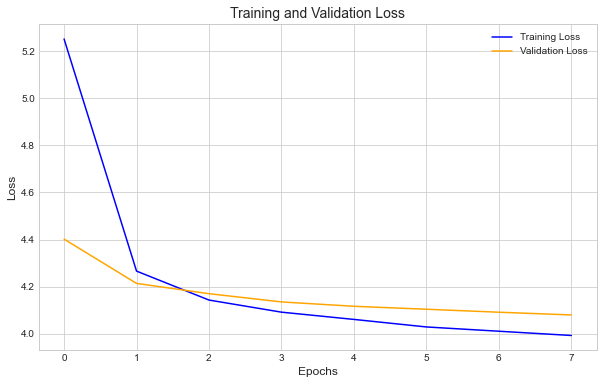

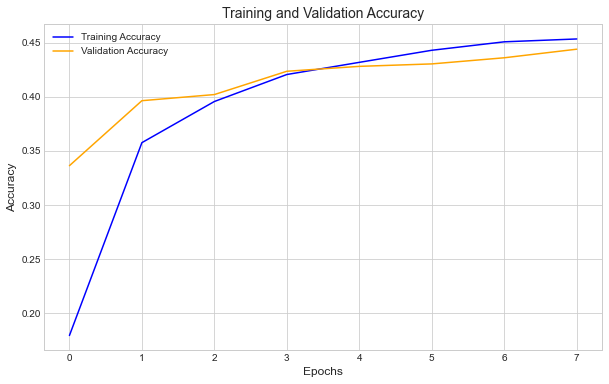

In [40]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.show()


1/1 [==============================] - 0s 233ms/step


C:\Users\Kanako\AppData\Local\Temp\ipykernel_26780\3509552699.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


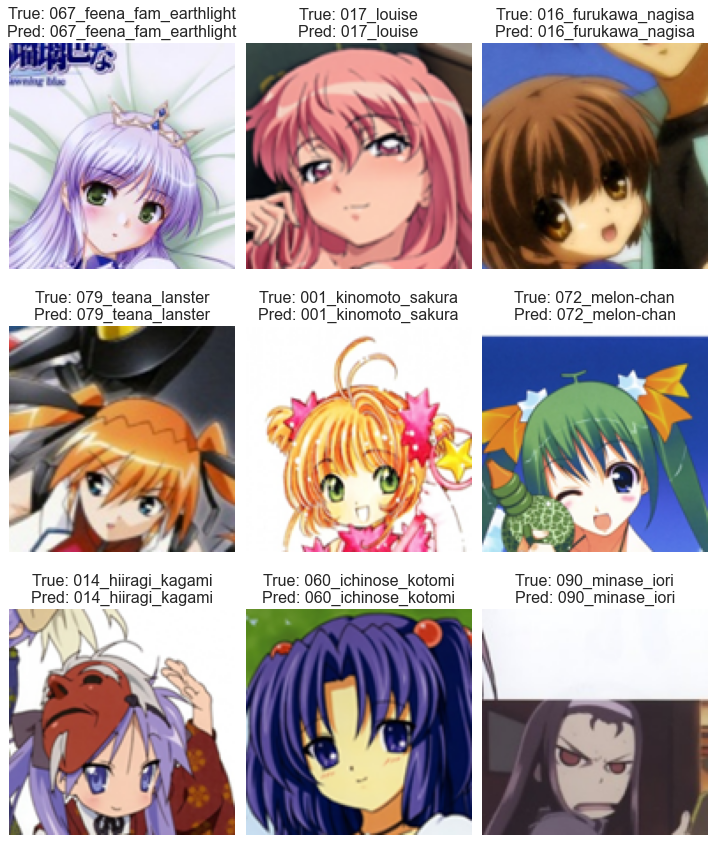

In [45]:
for images, labels in test_ds.take(1):
    predictions = efficientnet_model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10, 12))  
for i in range(9): 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    true_label = class_names[labels[i]]
    predicted_label = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=16)  # 字体大小为12
    plt.axis("off")

plt.subplots_adjust(wspace=0.2, hspace=0.4) 
plt.tight_layout()
plt.show()


## ResNet50

In [99]:
# model initialization
resnet_base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', 
                                                            include_top=False, 
                                                            input_shape=(128,128,3), 
                                                            classes=len(class_names))
resnet_base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))
x = resnet_base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(len(class_names))(x)

In [100]:
# training
resnet_model = keras.Model(inputs, outputs)

resnet_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
357/357 [==============================] - 13s 31ms/step - loss: 3.0566 - accuracy: 0.3636 - sparse_top_k_categorical_accuracy: 0.5859 - val_loss: 1.9436 - val_accuracy: 0.5317 - val_sparse_top_k_categorical_accuracy: 0.7868
Epoch 2/5
357/357 [==============================] - 10s 29ms/step - loss: 1.0956 - accuracy: 0.7281 - sparse_top_k_categorical_accuracy: 0.9064 - val_loss: 1.5600 - val_accuracy: 0.6134 - val_sparse_top_k_categorical_accuracy: 0.8435
Epoch 3/5
357/357 [==============================] - 10s 28ms/step - loss: 0.5986 - accuracy: 0.8620 - sparse_top_k_categorical_accuracy: 0.9631 - val_loss: 1.4262 - val_accuracy: 0.6565 - val_sparse_top_k_categorical_accuracy: 0.8673
Epoch 4/5
357/357 [==============================] - 10s 28ms/step - loss: 0.3314 - accuracy: 0.9356 - sparse_top_k_categorical_accuracy: 0.9880 - val_loss: 1.3312 - val_accuracy: 0.6678 - val_sparse_top_k_categorical_accuracy: 0.8696
Epoch 5/5
357/357 [==============================] - 10s 28m

In [101]:
# testingclasses=1000
results = resnet_model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

65/65 [==============================] - 2s 27ms/step - loss: 1.4314 - accuracy: 0.6753 - sparse_top_k_categorical_accuracy: 0.8702
test loss, test acc: [1.4314024448394775, 0.6752552390098572, 0.8701993227005005]


In [129]:
from keras.applications.imagenet_utils import decode_predictions 

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data


img_path = 'test_resized' + '/001_kinomoto_sakura' +'/face_189_227_85.png'
im = load_image(img_path)
a = np.zeros((1,128, 128, 3))
a[0] = im
pred = resnet_model.predict(a)

class_idx = np.argmax(pred)
print(class_names[class_idx])

img_path = 'test_resized' + '/013_saber' +'/face_401_110_84.png'
im = load_image(img_path)
a = np.zeros((1,128, 128, 3))
a[0] = im
pred = resnet_model.predict(a)

class_idx = np.argmax(pred)
print(class_names[class_idx])

img_path = 'test_resized' + '/033_kagamine_len' +'/face_398_398_125.png'
im = load_image(img_path)
a = np.zeros((1,128, 128, 3))
a[0] = im
pred = resnet_model.predict(a)

class_idx = np.argmax(pred)
print(class_names[class_idx])

001_kinomoto_sakura
077_yoshida_kazumi
047_sheryl_nome


In [23]:
# now train the same model with augmented dataset
resnet_model_aug = keras.Model(inputs, outputs)

resnet_model_aug.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

resnet_model_aug.fit(
  train_ds_augmented,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
1069/1069 [==============================] - 31s 27ms/step - loss: 1.1331 - accuracy: 0.7070 - sparse_top_k_categorical_accuracy: 0.9118 - val_loss: 1.7131 - val_accuracy: 0.6327 - val_sparse_top_k_categorical_accuracy: 0.8503
Epoch 2/5
1069/1069 [==============================] - 30s 28ms/step - loss: 0.4851 - accuracy: 0.8611 - sparse_top_k_categorical_accuracy: 0.9767 - val_loss: 1.7150 - val_accuracy: 0.6293 - val_sparse_top_k_categorical_accuracy: 0.8537
Epoch 3/5
1069/1069 [==============================] - 28s 26ms/step - loss: 0.2583 - accuracy: 0.9283 - sparse_top_k_categorical_accuracy: 0.9929 - val_loss: 1.8736 - val_accuracy: 0.6361 - val_sparse_top_k_categorical_accuracy: 0.8549
Epoch 4/5
1069/1069 [==============================] - 28s 26ms/step - loss: 0.1662 - accuracy: 0.9559 - sparse_top_k_categorical_accuracy: 0.9973 - val_loss: 1.8710 - val_accuracy: 0.6451 - val_sparse_top_k_categorical_accuracy: 0.8549
Epoch 5/5
1069/1069 [==============================]

In [24]:
# testing
results = resnet_model_aug.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

65/65 [==============================] - 2s 26ms/step - loss: 1.8063 - accuracy: 0.6506 - sparse_top_k_categorical_accuracy: 0.8615
test loss, test acc: [1.806342601776123, 0.6506316661834717, 0.8615160584449768]


## VGG16

In [15]:
vgg16_base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))
vgg16_base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))
x = vgg16_base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)

In [16]:
vgg16_model = keras.Model(inputs, outputs)

vgg16_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

vgg16_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
357/357 [==============================] - 16s 31ms/step - loss: 4.1477 - accuracy: 0.2547 - sparse_top_k_categorical_accuracy: 0.4491 - val_loss: 2.8426 - val_accuracy: 0.3900 - val_sparse_top_k_categorical_accuracy: 0.6361
Epoch 2/5
357/357 [==============================] - 9s 26ms/step - loss: 1.5509 - accuracy: 0.6167 - sparse_top_k_categorical_accuracy: 0.8361 - val_loss: 2.5156 - val_accuracy: 0.4875 - val_sparse_top_k_categorical_accuracy: 0.7279
Epoch 3/5
357/357 [==============================] - 10s 29ms/step - loss: 0.8075 - accuracy: 0.7859 - sparse_top_k_categorical_accuracy: 0.9409 - val_loss: 2.7016 - val_accuracy: 0.4728 - val_sparse_top_k_categorical_accuracy: 0.7347
Epoch 4/5
357/357 [==============================] - 10s 27ms/step - loss: 0.5031 - accuracy: 0.8603 - sparse_top_k_categorical_accuracy: 0.9743 - val_loss: 2.7684 - val_accuracy: 0.5034 - val_sparse_top_k_categorical_accuracy: 0.7574
Epoch 5/5
357/357 [==============================] - 10s 27ms

In [17]:
results = vgg16_model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

65/65 [==============================] - 2s 35ms/step - loss: 2.6562 - accuracy: 0.5294 - sparse_top_k_categorical_accuracy: 0.7759
test loss, test acc: [2.65616512298584, 0.529411792755127, 0.7758871912956238]


In [29]:
vgg16_model_aug = keras.Model(inputs, outputs)

vgg16_model_aug.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

vgg16_model_aug.fit(
  train_ds_augmented,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
1069/1069 [==============================] - 27s 25ms/step - loss: 1.2527 - accuracy: 0.6849 - sparse_top_k_categorical_accuracy: 0.8974 - val_loss: 3.3682 - val_accuracy: 0.4830 - val_sparse_top_k_categorical_accuracy: 0.7234
Epoch 2/5
1069/1069 [==============================] - 27s 25ms/step - loss: 0.6601 - accuracy: 0.8126 - sparse_top_k_categorical_accuracy: 0.9653 - val_loss: 3.7811 - val_accuracy: 0.4649 - val_sparse_top_k_categorical_accuracy: 0.7098
Epoch 3/5
1069/1069 [==============================] - 27s 25ms/step - loss: 0.4533 - accuracy: 0.8683 - sparse_top_k_categorical_accuracy: 0.9836 - val_loss: 4.2753 - val_accuracy: 0.4853 - val_sparse_top_k_categorical_accuracy: 0.7143
Epoch 4/5
1069/1069 [==============================] - 28s 26ms/step - loss: 0.3815 - accuracy: 0.8872 - sparse_top_k_categorical_accuracy: 0.9902 - val_loss: 4.7745 - val_accuracy: 0.4875 - val_sparse_top_k_categorical_accuracy: 0.7120
Epoch 5/5
1069/1069 [==============================]

In [30]:
results = vgg16_model_aug.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

65/65 [==============================] - 2s 24ms/step - loss: 5.0373 - accuracy: 0.5019 - sparse_top_k_categorical_accuracy: 0.7439
test loss, test acc: [5.037276744842529, 0.5019436478614807, 0.7439261674880981]


## VGG 19

In [18]:
vgg19_base_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(128,128,3))
vgg19_base_model.trainable = False

inputs = keras.Input(shape=(128, 128, 3))
x = vgg19_base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)

In [19]:
vgg19_model = keras.Model(inputs, outputs)

vgg19_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy','sparse_top_k_categorical_accuracy'])

vgg19_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
357/357 [==============================] - 13s 35ms/step - loss: 4.1769 - accuracy: 0.2421 - sparse_top_k_categorical_accuracy: 0.4466 - val_loss: 2.6580 - val_accuracy: 0.4104 - val_sparse_top_k_categorical_accuracy: 0.6474
Epoch 2/5
357/357 [==============================] - 12s 34ms/step - loss: 1.6131 - accuracy: 0.6022 - sparse_top_k_categorical_accuracy: 0.8241 - val_loss: 2.4661 - val_accuracy: 0.4399 - val_sparse_top_k_categorical_accuracy: 0.7086
Epoch 3/5
357/357 [==============================] - 11s 32ms/step - loss: 0.9020 - accuracy: 0.7588 - sparse_top_k_categorical_accuracy: 0.9275 - val_loss: 2.5163 - val_accuracy: 0.4751 - val_sparse_top_k_categorical_accuracy: 0.7426
Epoch 4/5
357/357 [==============================] - 11s 32ms/step - loss: 0.4892 - accuracy: 0.8631 - sparse_top_k_categorical_accuracy: 0.9761 - val_loss: 2.6271 - val_accuracy: 0.5034 - val_sparse_top_k_categorical_accuracy: 0.7517
Epoch 5/5
357/357 [==============================] - 11s 32m

In [20]:
results = vgg19_model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

65/65 [==============================] - 2s 29ms/step - loss: 2.8476 - accuracy: 0.5007 - sparse_top_k_categorical_accuracy: 0.7453
test loss, test acc: [2.8476338386535645, 0.5007292032241821, 0.7452600598335266]


In [34]:
vgg19_model_aug = keras.Model(inputs, outputs)

vgg19_model_aug.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

vgg19_model_aug.fit(
  train_ds_augmented,
  validation_data=val_ds,
  epochs=5
    
)

Epoch 1/5
1069/1069 [==============================] - 32s 30ms/step - loss: 1.6303 - accuracy: 0.5979 - sparse_top_k_categorical_accuracy: 0.8451 - val_loss: 2.9496 - val_accuracy: 0.4717 - val_sparse_top_k_categorical_accuracy: 0.7483
Epoch 2/5
1069/1069 [==============================] - 32s 30ms/step - loss: 0.8368 - accuracy: 0.7665 - sparse_top_k_categorical_accuracy: 0.9443 - val_loss: 3.3018 - val_accuracy: 0.4785 - val_sparse_top_k_categorical_accuracy: 0.7415
Epoch 3/5
1069/1069 [==============================] - 32s 30ms/step - loss: 0.5691 - accuracy: 0.8324 - sparse_top_k_categorical_accuracy: 0.9743 - val_loss: 4.1784 - val_accuracy: 0.4887 - val_sparse_top_k_categorical_accuracy: 0.7268
Epoch 4/5
1069/1069 [==============================] - 33s 31ms/step - loss: 0.4533 - accuracy: 0.8661 - sparse_top_k_categorical_accuracy: 0.9846 - val_loss: 4.4740 - val_accuracy: 0.4841 - val_sparse_top_k_categorical_accuracy: 0.7426
Epoch 5/5
1069/1069 [==============================]

In [35]:
results = vgg19_model_aug.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

65/65 [==============================] - 2s 29ms/step - loss: 4.8278 - accuracy: 0.5180 - sparse_top_k_categorical_accuracy: 0.7488
test loss, test acc: [4.827785015106201, 0.5179786086082458, 0.7487852573394775]


## Data preprocessing for Inception and Xception models

In [22]:
def read_as_np_arrays(dataset):
    
    x = []
    y = []
    i = 0
    for cls in classes_dir:
        for name in os.listdir(root_dir+ dataset + '/' + cls):
            image = Image.open(root_dir + dataset + '/' + cls+'/'+name)
            image = np.array(image)
            if image.shape == (128,128,3):
                x.append(np.array(image))
                y.append(i)
        i += 1
        print(cls)
        
    x = np.array(x)
    y = np.array(y)
    
    return [x, y]

In [23]:
x_train, y_train = read_as_np_arrays("train_resized")

038_takara_miyuki
121_arcueid_brunestud
152_maka_albarn
138_kanu
039_yagami_hayate
190_kawashima_ami
040_flandre_scarlet
022_kururugi_suzaku
024_fujibayashi_kyou
023_hiiragi_tsukasa
178_milfeulle_sakuraba
999_ito_chika
028_tainaka_ritsu
174_hayama_mizuki
005_lelouch_lamperouge
004_takamachi_nanoha
092_shindou_kei
044_nakano_azusa
067_feena_fam_earthlight
181_allen_walker
058_kochiya_sanae
070_nijihara_ink
195_erio_mondial
041_saigyouji_yuyuko
018_kagamine_rin
186_nanael
197_illyasviel_von_einzbern
015_c.c
106_nia
079_teana_lanster
013_saber
127_setsuna_f_seiei
119_takatsuki_yayoi
103_reinforce_zwei
017_louise
168_asagiri_mai
188_aika_granzchesta
125_sakai_yuuji
100_houjou_satoko
098_mizunashi_akari
062_matou_sakura
112_hinamori_amu
026_tohsaka_rin
042_tsukimura_mayu
091_komaki_manaka
158_enma_ai
143_miura_azusa
157_ogasawara_sachiko
189_akizuki_ritsuko
159_andou_mahoro
025_souryuu_asuka_langley
144_kotegawa_yui
084_okazaki_tomoya
088_vita
010_izumi_konata
104_fukuzawa_yumi
086_tsuruya


In [24]:
x_train_aug, y_train_aug = read_as_np_arrays("train_augmented")

038_takara_miyuki
121_arcueid_brunestud
152_maka_albarn
138_kanu
039_yagami_hayate
190_kawashima_ami
040_flandre_scarlet
022_kururugi_suzaku
024_fujibayashi_kyou
023_hiiragi_tsukasa
178_milfeulle_sakuraba
999_ito_chika
028_tainaka_ritsu
174_hayama_mizuki
005_lelouch_lamperouge
004_takamachi_nanoha
092_shindou_kei
044_nakano_azusa
067_feena_fam_earthlight
181_allen_walker
058_kochiya_sanae
070_nijihara_ink
195_erio_mondial
041_saigyouji_yuyuko
018_kagamine_rin
186_nanael
197_illyasviel_von_einzbern
015_c.c
106_nia
079_teana_lanster
013_saber
127_setsuna_f_seiei
119_takatsuki_yayoi
103_reinforce_zwei
017_louise
168_asagiri_mai
188_aika_granzchesta
125_sakai_yuuji
100_houjou_satoko
098_mizunashi_akari
062_matou_sakura
112_hinamori_amu
026_tohsaka_rin
042_tsukimura_mayu
091_komaki_manaka
158_enma_ai
143_miura_azusa
157_ogasawara_sachiko
189_akizuki_ritsuko
159_andou_mahoro
025_souryuu_asuka_langley
144_kotegawa_yui
084_okazaki_tomoya
088_vita
010_izumi_konata
104_fukuzawa_yumi
086_tsuruya


In [25]:
x_test, y_test = read_as_np_arrays("test_resized")

038_takara_miyuki
121_arcueid_brunestud
152_maka_albarn
138_kanu
039_yagami_hayate
190_kawashima_ami
040_flandre_scarlet
022_kururugi_suzaku
024_fujibayashi_kyou
023_hiiragi_tsukasa
178_milfeulle_sakuraba
999_ito_chika
028_tainaka_ritsu
174_hayama_mizuki
005_lelouch_lamperouge
004_takamachi_nanoha
092_shindou_kei
044_nakano_azusa
067_feena_fam_earthlight
181_allen_walker
058_kochiya_sanae
070_nijihara_ink
195_erio_mondial
041_saigyouji_yuyuko
018_kagamine_rin
186_nanael
197_illyasviel_von_einzbern
015_c.c
106_nia
079_teana_lanster
013_saber
127_setsuna_f_seiei
119_takatsuki_yayoi
103_reinforce_zwei
017_louise
168_asagiri_mai
188_aika_granzchesta
125_sakai_yuuji
100_houjou_satoko
098_mizunashi_akari
062_matou_sakura
112_hinamori_amu
026_tohsaka_rin
042_tsukimura_mayu
091_komaki_manaka
158_enma_ai
143_miura_azusa
157_ogasawara_sachiko
189_akizuki_ritsuko
159_andou_mahoro
025_souryuu_asuka_langley
144_kotegawa_yui
084_okazaki_tomoya
088_vita
010_izumi_konata
104_fukuzawa_yumi
086_tsuruya


## XCeption

In [26]:
x_train_xception = tf.keras.applications.xception.preprocess_input(x_train)
x_train_aug_xception = tf.keras.applications.xception.preprocess_input(x_train_aug)
x_test_xception = tf.keras.applications.xception.preprocess_input(x_test)

In [27]:
#train_dataset = tf.data.Dataset.from_tensor_slices((x_train_aug, y_train_aug))

In [28]:
inputs = keras.Input(shape=(128, 128, 3))

xception_base_model = tf.keras.applications.xception.Xception(input_tensor=inputs, weights='imagenet', include_top=False, input_shape=(128,128,3))
xception_base_model.trainable = False

#x = xception_base_model(inputs, training=False)
x = xception_base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)

In [29]:
xception_model = keras.Model(inputs, outputs)

xception_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
)

xception_model.fit(
    x = x_train_xception,
    y = y_train,
    epochs=5
)

Epoch 1/5
357/357 [==============================] - 11s 27ms/step - loss: 3.7423 - accuracy: 0.2030 - sparse_top_k_categorical_accuracy: 0.4172
Epoch 2/5
357/357 [==============================] - 9s 26ms/step - loss: 2.1059 - accuracy: 0.4917 - sparse_top_k_categorical_accuracy: 0.7561
Epoch 3/5
357/357 [==============================] - 10s 27ms/step - loss: 1.3776 - accuracy: 0.6561 - sparse_top_k_categorical_accuracy: 0.8782
Epoch 4/5
357/357 [==============================] - 10s 28ms/step - loss: 0.9302 - accuracy: 0.7663 - sparse_top_k_categorical_accuracy: 0.9322
Epoch 5/5
357/357 [==============================] - 10s 28ms/step - loss: 0.6231 - accuracy: 0.8476 - sparse_top_k_categorical_accuracy: 0.9668


In [30]:
results = xception_model.evaluate(x = x_test_xception, y = y_test)
print("test loss, test acc:", results)

92/92 [==============================] - 3s 30ms/step - loss: 2.1651 - accuracy: 0.5150 - sparse_top_k_categorical_accuracy: 0.7587
test loss, test acc: [2.165057420730591, 0.5149762034416199, 0.7586793899536133]


In [38]:
# xception_model_aug = keras.Model(inputs, outputs)

# xception_model_aug.compile(
#   optimizer='adam',
#   loss=tf.losses.SparseCategoricalCrossentropy(),
#   metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
# )

# xception_model_aug.fit(
#     x = x_train_aug_xception,
#     y = y_train_aug,
#     epochs=5
# )

In [ ]:
results = xception_model_aug.evaluate(x = x_test_xception, y = y_test)
print("test loss, test acc:", results)

## Inception

In [33]:
x_train_inception = tf.keras.applications.inception_v3.preprocess_input(x_train)
x_test_inception = tf.keras.applications.inception_v3.preprocess_input(x_test)

In [34]:
# x_train_aug_inception = tf.keras.applications.inception_v3.preprocess_input(x_train_aug)

In [35]:
inputs = keras.Input(shape=(128, 128, 3))

inception_base_model = tf.keras.applications.inception_v3.InceptionV3(input_tensor=inputs, weights='imagenet', include_top=False, input_shape=(128,128,3))
inception_base_model.trainable = False

x = inception_base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(len(class_names), activation='softmax')(x)

In [36]:
inception_model = keras.Model(inputs, outputs)

inception_model.compile(
  optimizer='rmsprop',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

inception_model.fit(
    x = x_train_inception,
    y = y_train,
    epochs=5
)

Epoch 1/5
357/357 [==============================] - 11s 24ms/step - loss: 4.4702 - accuracy: 0.1253 - sparse_top_k_categorical_accuracy: 0.2954
Epoch 2/5
357/357 [==============================] - 8s 23ms/step - loss: 2.7445 - accuracy: 0.3547 - sparse_top_k_categorical_accuracy: 0.6305
Epoch 3/5
357/357 [==============================] - 8s 22ms/step - loss: 2.0616 - accuracy: 0.4847 - sparse_top_k_categorical_accuracy: 0.7642
Epoch 4/5
357/357 [==============================] - 8s 22ms/step - loss: 1.6190 - accuracy: 0.5890 - sparse_top_k_categorical_accuracy: 0.8356
Epoch 5/5
357/357 [==============================] - 8s 22ms/step - loss: 1.2694 - accuracy: 0.6644 - sparse_top_k_categorical_accuracy: 0.8914


In [37]:
results = inception_model.evaluate(x = x_test_xception, y = y_test)
print("test loss, test acc:", results)

92/92 [==============================] - 3s 28ms/step - loss: 3.5521 - accuracy: 0.3251 - sparse_top_k_categorical_accuracy: 0.6232
test loss, test acc: [3.552079200744629, 0.32505106925964355, 0.6232130527496338]
